In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
from PIL import Image
import os
from torch.optim import lr_scheduler
from database2 import DehazingDataset

In [2]:
# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Discriminator
# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 1, 4, stride=2, padding=1)
        )

    def forward(self, x):
        x = self.model(x)
        # Perform global average pooling
        x = torch.mean(x, dim=(2, 3))
        return torch.sigmoid(x)



In [3]:
root_dir = 'Task2Dataset'
train_dir = os.path.join(root_dir, 'train')
val_dir = os.path.join(root_dir, 'val')
transform = transforms.Compose([
                                #  transforms.Resize((224, 224)), # ASSUMING NO NEED FOR RESIZING AS ALL IMAGES ARE ALREADY 256*256
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                 ])

train_dataset = DehazingDataset(train_dir, transform)
val_dataset = DehazingDataset(val_dir, transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

In [4]:
# Define the generator and discriminator
generator = Generator()
discriminator = Discriminator()


# Define the loss function and optimizer
bce_loss = nn.BCELoss()
l1_loss = nn.L1Loss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [5]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    # schedulerG.step()
    # schedulerD.step()

    # Initialize total losses for the epoch
    g_total_loss = 0
    d_total_loss = 0

    # Training the generator and discriminator
    for hazy_imgs, clean_imgs in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        # Training the discriminator
        discriminator.zero_grad()
        real_imgs = clean_imgs

        # GENERATOR TAKES HAZY IMAGES AS INPUT
        fake_imgs = generator(hazy_imgs)

        real_labels = torch.ones(real_imgs.size(0), 1)
        fake_labels = torch.zeros(fake_imgs.size(0), 1)

        # PREDICTIONS OF DISCRIMINATOR FOR REAL IMAGES
        real_outputs = discriminator(real_imgs)

        # PREDICTIONS OF DISCRIMINATOR FOR FAKE IMAGES
        fake_outputs = discriminator(fake_imgs.detach())

        d_loss_real = bce_loss(real_outputs, real_labels)
        d_loss_fake = bce_loss(fake_outputs, fake_labels)
        d_loss = d_loss_real + d_loss_fake

        # Update discriminator
        d_loss.backward()
        optimizer_D.step()

        # Training the generator
        generator.zero_grad()
        fake_imgs = generator(hazy_imgs)
        fake_outputs = discriminator(fake_imgs)
        g_loss = bce_loss(fake_outputs, real_labels)

        # Compute reconstruction loss
        g_res_loss = l1_loss(fake_imgs, clean_imgs)

        # Update generator
        g_complete_loss = (g_loss + g_res_loss)
        g_complete_loss.backward()
        optimizer_G.step()

        # Add discriminator and generator losses to total losses
        d_total_loss += d_loss.item()
        g_total_loss += g_loss.item() + g_res_loss.item()  # Add reconstruction loss to total generator loss

    # Print losses
    print(f"Epoch [{epoch + 1}/{num_epochs}], Generator Loss: {g_total_loss / len(train_dataloader):.4f}, Discriminator Loss: {d_total_loss / len(train_dataloader):.4f}")

# Save the trained models
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')


Epoch 1/10: 100%|███████████████████████████| 239/239 [1:39:44<00:00, 25.04s/it]


Epoch [1/10], Generator Loss: 1.6245, Discriminator Loss: 1.2428


Epoch 2/10: 100%|███████████████████████████| 239/239 [1:33:41<00:00, 23.52s/it]


Epoch [2/10], Generator Loss: 2.2627, Discriminator Loss: 0.9729


Epoch 3/10: 100%|███████████████████████████| 239/239 [1:12:59<00:00, 18.32s/it]


Epoch [3/10], Generator Loss: 3.1085, Discriminator Loss: 0.6291


Epoch 4/10: 100%|█████████████████████████████| 239/239 [57:36<00:00, 14.46s/it]


Epoch [4/10], Generator Loss: 3.6031, Discriminator Loss: 0.4862


Epoch 5/10: 100%|███████████████████████████| 239/239 [1:00:02<00:00, 15.07s/it]


Epoch [5/10], Generator Loss: 3.6330, Discriminator Loss: 0.5097


Epoch 6/10: 100%|█████████████████████████████| 239/239 [59:22<00:00, 14.91s/it]


Epoch [6/10], Generator Loss: 3.6801, Discriminator Loss: 0.4766


Epoch 7/10: 100%|███████████████████████████| 239/239 [1:04:19<00:00, 16.15s/it]


Epoch [7/10], Generator Loss: 3.7570, Discriminator Loss: 0.4488


Epoch 8/10: 100%|█████████████████████████████| 239/239 [51:34<00:00, 12.95s/it]


Epoch [8/10], Generator Loss: 3.7230, Discriminator Loss: 0.4509


Epoch 9/10: 100%|█████████████████████████████| 239/239 [50:35<00:00, 12.70s/it]


Epoch [9/10], Generator Loss: 3.6805, Discriminator Loss: 0.5081


Epoch 10/10: 100%|████████████████████████████| 239/239 [47:48<00:00, 12.00s/it]

Epoch [10/10], Generator Loss: 3.7940, Discriminator Loss: 0.4780


In [6]:
torch.save(generator.state_dict(), 'generator_l1loss_noscheduler.pth')
torch.save(discriminator.state_dict(), 'discriminator_l1loss_noscheduler.pth')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IndexError: index 3 is out of bounds for dimension 0 with size 3

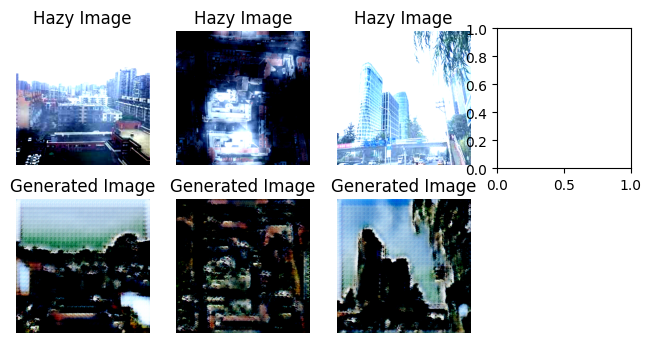

In [7]:
num_samples = 5
import matplotlib.pyplot as plt

generated_images = generator(hazy_imgs[:num_samples]).detach().cpu()

plt.figure(figsize=(10, 4))
for i in range(num_samples):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(hazy_imgs[i].permute(1, 2, 0))  # Assuming images are in CHW format
    plt.title('Hazy Image')
    plt.axis('off')

    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.imshow(generated_images[i].permute(1, 2, 0))  # Assuming images are in CHW format
    plt.title('Generated Image')
    plt.axis('off')

plt.tight_layout()
plt.show()
            